In [28]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=False)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

![title](geometry_hrmc.png)

In [34]:
# 상수 정의
deg_to_rad = np.pi/180.0
rad_to_deg = 180.0/np.pi




# 함수들
def generate_slit_test(slit_open_deg = 5.0, slit_period_deg=15.0, slit_angle_start=-77.5):
    slit_open_list_rad0 = []
    slit_open_list_deg0 = []
    for t_ang in np.arange(slit_angle_start, 90.0-slit_open_deg, slit_period_deg):
        slit_open_list_rad0.append((t_ang*deg_to_rad, (t_ang+slit_open_deg)*deg_to_rad))
        slit_open_list_deg0.append((t_ang, t_ang+slit_open_deg))
    return slit_open_list_deg0, slit_open_list_rad0


def generate_slit_kkh(N_slits=12, slit_deg=7.0, slat_deg=7.0):
    """
    김기현 교수 IEEE 2019 논문에 따른 slit angle 생성.
    
    N_slit : number of slit
    slit_deg : slit open angle (deg)
    slat_deg : slat angle (deg)
    
    return
    ------
    slit opens in deg
    
    """
    slit_cover = slit_deg*N_slits + slat_deg*(N_slits-1)
    slit_start = -slit_cover/2.0
    print(slit_cover, slit_start)
    return generate_slit_test(slit_deg, slit_deg+slat_deg, slit_start)[0]
    
def get_closed_from_slit_open(open_deg):
    d0=-90.0
    d1=90.0
    result = []
    for sl in open_deg:
        result.append((d0, sl[0]))
        d0 = sl[1]
    result.append((d0, 90.0))
    return result
    
def get_solution2(a,b,c):
    """
    $ax^2+bx+c=0$ 의 2차방정식의 해를 return 한다.
    
    $D=\sqrt{b^2-4ac}$ 하 할 때,
    
    answer :
    
    (-b+D)/2, (-b-D)/2a
    
    """
    D=np.sqrt(b**2-4*a*c)
    
    if np.abs(a)<1.0e-19 :
        return None
    
    return ((-b+D)/(2*a), (-b-D)/(2*a))

def cartesian_to_spherical(x, y, z):
    """
    args
    ----
    x, y, z
    
    return sperical coordinate from given cartesian coordinate (x, y, z) 
    
    return
    ---
    (r, theta [deg], phi [deg])
    
    Warning : if x=y=z=0.0, return (0.0, 0.0, 0.0)
    """
    
    theta = np.zeros(x.shape)
    phi = np.zeros(x.shape)
    r=np.sqrt(x**2+y**2+z**2)
    r0ind=np.where(r==0.0)
    rind = np.where(r>0.0)
    x0ind = np.where(x==0.0)
    
    theta[rind] = np.arccos(z[rind]/r[rind])
    phi= np.arctan2(y, x)
    
    return (r, theta*rad_to_deg, phi*rad_to_deg)

def get_position_on_Rsphere_cartesian(source_position, Rsp, Y, Z):
    """
    hemisphere의 반경을 R 이라 하자. source가 (x, y, z)에 위치할 때 source에서 
    각 pixel의 중앙으로 직선을 그렸을 때 반경 R 인 구와 만나는 점의 3차원 좌표
    를 return 한다.
    
    args
    -------
    source_position : list/tuple/array with 3 elements in mm 
    Rsp : spherical collimator 반경
    Y : 각 pixel의 y값을 나타내는 nxn array
    Z : 각 pixel의 z값을 나타내는 nxn array
    
    return
    ------
    (XR, YR, ZR)
       
    """
    
    xs, ys, zs = source_position[0], source_position[1], source_position[2]
    
    A=xs**2+(ys-Y)**2+(zs-Z)**2
    B=2.0*(Y*(ys-Y)+Z*(zs-Z))
    #C=Y**2+Z**2-d_pixel**2
    C=Y**2+Z**2-Rsp**2
    
    t1, t2=get_solution2(A, B, C)
    
    XR=xs*t1
    YR=(ys-Y)*t1+Y
    ZR=(zs-Z)*t1+Z
    
    return (XR, YR, ZR)

def get_position_on_Rsphere_spherical(source_position, Rph, Y, Z):
    XR, YR, ZR = get_position_on_Rsphere_cartesian(source_position, Rph, Y, Z)
    #ex_angle_mask =np.fromiter((is_open(ai) for ai in aa), aa.dtype)
    M_R, M_theta, M_phi = cartesian_to_spherical(XR, YR, ZR)
    #print(M_R.max(), M_R.min(),M_theta.min(), M_theta.max(), M_phi.min(), M_phi.max())
    return M_theta, M_phi

def calc_valid_phi(source_position, d_pixel, Y, Z):
    Mth, Mph = get_position_on_Rsphere_spherical(source_position, d_pixel, Y, Z)
    M1=np.fromiter((is_open(mi) for mi in Mph.flatten()), Mph.dtype)
    return M1.reshape(Mph.shape)


# def calc_rotation_old(sample_position = [65, 65, 0], rotation_step=1.0, rotation_direction=-1):
#     zs, xs, ys = sample_position[0], sample_position[1], sample_position[2]
#     rs = np.sqrt(xs**2+ys**2+zs**2)
#     theta0=np.arctan2(np.sqrt(xs**2+ys**2), zs)
#     phi0 = np.arctan2(ys, xs)
#     newx=[]
#     newy=[]
#     newz=[]
#     for dphi_deg in np.arange(0.0, 180.0+rotation_step/2.0, rotation_step):
#         dphi = dphi_deg*deg_to_rad*(rotation_direction)
#         nx = rs*np.cos(theta0)
#         ny = rs*np.sin(theta0)*np.cos(phi0+dphi)
#         nz = rs*np.sin(theta0)*np.sin(phi0+dphi)
#         newx.append(nx)
#         newy.append(ny)
#         newz.append(nz)
#     return np.array(newx), np.array(newy), np.array(newz)

# def calc_rotation_old2(sample_position = [65, 65, 0], rotation_step=1.0, rotation_direction=-1):
#     zs, xs, ys = sample_position[0], sample_position[1], sample_position[2]
#     rs = np.sqrt(xs**2+ys**2+zs**2)
#     theta0 = np.arctan2(np.sqrt(xs**2+ys**2), zs)
#     phi0 = np.arctan2(ys, xs)
#     dphi = np.arange(0.0, 180.0+rotation_step/2.0, rotation_step)*deg_to_rad*(rotation_direction)
#     newx = np.ones(dphi.shape)*rs*np.cos(theta0)
#     newy = rs*np.sin(theta0)*np.cos(phi0+dphi)
#     newz = rs*np.sin(theta0)*np.sin(phi0+dphi)
#     return newx, newy, newz

def calc_rotation(position, angle):
    """
    angle : rotation angle in degree
    """
    zz, xx, yy = position[0], position[1], position[2]
    dphi = angle*deg_to_rad
    rr = np.sqrt(xx**2+yy**2+zz**2)
    theta0=np.arctan2(np.sqrt(xx**2+yy**2), zz)
    phi0 = np.arctan2(yy, xx)
    newx = rr*np.cos(theta0)
    newy = rr*np.sin(theta0)*np.cos(phi0+dphi)
    newz = rr*np.sin(theta0)*np.sin(phi0+dphi)
    return (newx, newy, newz)
        
def generate_solid_angle(source_position):
    xs, ys, zs = source_position[0], source_position[1], source_position[2]
    n_area = dy * dz
    M_cos = xs/np.sqrt((xs)**2+(ys-YY)**2+(zs-ZZ)**2)
    
    return M_cos
    

def plot_hemispherical_collimoator(dw, R1, slits1, R2=None, slits2=None, rotation_angle=30.0, view_ele=30.0, view_azim=45.0):
    th0 = np.linspace(0.0, np.pi, 100)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.view_init(view_ele, view_azim)
    cslits1 = get_closed_from_slit_open(slits1)
    cslits2 = get_closed_from_slit_open(slits2)
    rangle = rotation_angle*deg_to_rad
    for sl1 in cslits1:
        ph0 = np.linspace(sl1[0]*deg_to_rad, sl1[1]*deg_to_rad, 100)
        Theta, Phi = np.meshgrid(th0, ph0)
        X1 = R1 * np.sin(Theta) * np.cos(Phi)
        Y1 = R1 * np.sin(Theta) * np.sin(Phi)
        Z1 = R1 * np.cos(Theta)
        
        YY1 = Y1*np.cos(rangle)+Z1*np.sin(rangle)
        ZZ1 = -1.*Y1*np.sin(rangle)+Z1*np.cos(rangle)
        
        plot = ax.plot_surface(
            X1, YY1, ZZ1, rstride=1, cstride=1, color="b",
            linewidth=0, antialiased=False, alpha=0.3)
        
    for sl2 in cslits2:
        ph0 = np.linspace(sl2[0]*deg_to_rad, sl2[1]*deg_to_rad, 100)
        Theta, Phi = np.meshgrid(th0, ph0)
        X2 = R2 * np.sin(Theta) * np.cos(Phi)
        Y2 = R2 * np.sin(Theta) * np.sin(Phi)
        Z2 = R2 * np.cos(Theta)
        
        YY2 = Y2*np.cos(rangle)+Z2*np.sin(rangle)
        ZZ2 = -1.*Y2*np.sin(rangle)+Z2*np.cos(rangle)
        
        plot = ax.plot_surface(
            X2, YY2, ZZ2, rstride=1, cstride=1, color="r",
            linewidth=0, antialiased=False, alpha=0.4)
    
    rects  = [[[0, dw, dw], [0, -dw, dw], [0, -dw, -dw], [0, dw, -dw ], [0, 0, 0]]]    
    ax.add_collection3d(Poly3DCollection(rects))       
    
    world_limits = ax.get_w_lims()
    ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))    
    
class hrmc(object):
    """
    Hemispherical Radial modulation collimator
    
    collimator dimension
    -----
    self.R_out : 바깥쪽 collimator 반경 (mm).
    self.R_in  : 안쪽 collimator 반경 (mm).
    self.R_d   : 검출기 폭=검출기 너비의 반 (mm).
    
    self.slit_opens : slit이 open 된 phi angle
    
    self.slit_open_deg : slit open phi angle list [deg] 
    self.slit_open_rad : slit open phi angle list [rad]
    
    self.T_out : transmission of outer hemisperical collimator
    self.T_in  : transmission of inner hemisperical collimator
    
    self.source_position : [x, y, z]
    """
    def __init__(self, R_out=95.0, R_in = 25.0, Dl=20.0, Nbins=100):
        
        self.R_out = R_out
        self.R_in = R_in

        self.R_d = Dl/2.0
        self.Nbins = int(Nbins)
        
        self.Dy, self.Dz, self.Dr = None, None, None
        
        self.Cout_slit_open_deg = None
        self.Cout_slit_open_rad = None
        
        self.Cin_slit_open_deg = None
        self.Cin_slit_open_deg = None
        
        
        self.T_out = 0.0
        self.T_in = 0.0
        
        self.source_position =  np.array([0., 0., 0.])
        
        self.init_detector_pixel(self.Nbins)
        
        self.mode_detector_stop = True
        
    def __str__(self):
        result="Hemispherical radial modulation collimator\n"
        result+="-----------------------------------------\n"
        result+=f"Outer radius : {self.R_out:.2f} [mm]\n"
        result+=f"Inner radius : {self.R_in:.2f} [mm]\n"
        result+=f"Detector width and height : {self.R_d*2:.2f} [mm]\n"
        result+=f"Number of detector bins : {self.Nbins} x {self.Nbins}\n"
        result+=f"Transmission of outer collimator : {self.T_out:.3f}\n"
        result+=f"Transmission of inner collimator : {self.T_in:.3f}\n"
        result+=f"Source position : [{self.source_position[0]:.3f}, \
            {self.source_position[1]:.3f}, {self.source_position[2]:.3f}]\n"
        return result
        
    def __repr__(self):
        return self.__str__()
        
    def init_detector_pixel(self, Nbins = None):
        if Nbins== None:
            Nbins = self.Nbins
        y0 = np.linspace(-1.0*self.R_d, self.R_d, Nbins)
        z0 = np.linspace(-1.0*self.R_d, self.R_d, Nbins)
        y1, z1 = 0.5*(y0[1:]+y0[:-1]), 0.5*(z0[1:]+z0[:-1])
        dy, dz = y0[1]-y0[0], z0[1]-z0[0]

        self.Dy, self.Dz = np.meshgrid(y1, z1)
        self.Dr = np.sqrt(self.Dy**2+self.Dz**2)
        
    
    
    def is_open(self, angle_phi):
        """
        angle_phi : phi angle in degree
        
        주어진 phi angle이 open이면 True 를 closed 이면 False 를 리턴한다.
        """
        result = False
        angrad = angle*deg_to_rad

        for angs in self.slit_open_list_rad:
            if angrad < angs[0]:
                pass
            elif (angrad >= angs[0]) and (angrad <= angs[1]):
                result = True
                break

        return result

    def set_detector_stop_mode(self, mode = False):
        """
        mode == True 이면 collimator rotation 시 detector는 움직이지 않음.
        mode == False 이면 collimator 회전과 함까 detector도 움직임.
        """
        self.mode_detector_stop = bool(mode)
        
        
    def set_detector(self, width=20., Nbins=100):
        self.R_d = width/2.0
        self.Nbins = int(Nbins)
        
    def set_slit_deg(self, Cin_slit_deg, Cout_slit_deg):
        self.Cout_slit_open_deg = np.array(Cout_slit_deg)
        self.Cout_slit_open_rad = self.Cout_slit_open_deg*deg_to_rad
        self.Cin_slit_open_deg = np.array(Cin_slit_deg)
        self.Cin_slit_open_rad = self.Cin_slit_open_deg*deg_to_rad
        
    def set_slit_rad(self, Cin_slit_rad, Cout_slit_rad):
        self.Cin_slit_open_rad = np.array(Cin_slit_rad)
        self.Cin_slit_open_deg = self.Cin_slit_open_rad*rad_to_deg
        self.Cout_slit_open_rad = np.array(Cout_slit_rad)
        self.Cout_slit_open_deg = self.Cout_slit_open_rad*rad_to_deg
        
    def set_tramsmission(self, inner=0.0, outer=0.0):
        if (inner <=1.0) and (inner >=0.0) and (outer <=1.0) and (outer >=1.0):
            self.T_in=inner
            self.T_out = outer
        else :
            print("Transmission should be in a range [0.0, 1.0].")
    
    def set_source_position(self, x, y, z):
        self.source_position = np.array([x, y, z], dtype=np.double)

    
    def calc_rotation_source(self, rotation_angle):
        """
        Counterclockwise rotation of source
        """
        return calc_rotation(self.source_position, rotation_angle)
    
    def calc_rotation_detector(self, rotation_angle):
        """
        Counterclockwise rotation of detector
        """
        return calc_rotation([np.zeros(self.Dy.shape), self.Dy, self.Dz], rotation_angle)
    
    def calc_valid_phi(self, R_coll, tr=0.0):
        """
        R_coll : collimator radius
        """
        Mth, Mph = get_position_on_Rsphere_spherical(self.source_position, R_coll, Y, Z)
        M1=np.fromiter((is_open(mi) for mi in Mph.flatten()), Mph.dtype)
        return (M1.reshape(Mph.shape)*(1-tr)+tr)

    
    def calc_transmission_by_rotation(self, rotation_angle):
        """
        Outer collimator 와 inner collimator 에 의한 transmission을 계산한다.
        """
        # rotated source position (물리적으로는 collimator가 움직이지만, 계산에서는
        # source 와 detector가 반대 방향으로 회전함에 유의하라.)
        nsp = self.calc_rotation_source(rotation_angle) # new source position
        
        if self.mode_detector_stop == False :
            DX, DY, DZ = self.calc_rotation_detector(rotation_angle)
        else :
            DX, DY, DZ = np.zeros(self.Dy.shape), self.Dy.copy(), self.Dz.copy()
        
        M_theta0, M_phi0 = get_position_on_Rsphere_spherical(nsp , self.R_out, DY, DZ)
        MK0 = calc_valid_phi(source_position, R_out, Ym, Zm)
        return MK0
        M_theta1, M_phi1 = get_position_on_Rsphere_spherical(nsp , self.R_in, DY, DZ)
        MK1 = calc_valid_phi(source_position, R_in, Ym, Zm)
        
    def plot_collimator(self, rotation_angle_deg):
        plot_hemispherical_collimoator(self.R_d, self.R_out, self.Cout_slit_open_deg, self.R_in, \
                                       self.Cin_slit_open_deg, view_ele=30.0, view_azim=45.0)
        
        
        
        

In [42]:
a=hrmc()
coll = generate_slit_kkh()
a.set_slit_deg(coll, coll)
a.set_source_position(700, 700, 100)

161.0 -80.5


In [43]:
a.Cout_slit_open_rad

array([[-1.40499005, -1.282817  ],
       [-1.16064395, -1.0384709 ],
       [-0.91629786, -0.79412481],
       [-0.67195176, -0.54977871],
       [-0.42760567, -0.30543262],
       [-0.18325957, -0.06108652],
       [ 0.06108652,  0.18325957],
       [ 0.30543262,  0.42760567],
       [ 0.54977871,  0.67195176],
       [ 0.79412481,  0.91629786],
       [ 1.0384709 ,  1.16064395],
       [ 1.282817  ,  1.40499005]])

In [46]:
a.source_position

array([700., 700., 100.])

In [45]:
MM=a.calc_transmission_by_rotation(0.0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

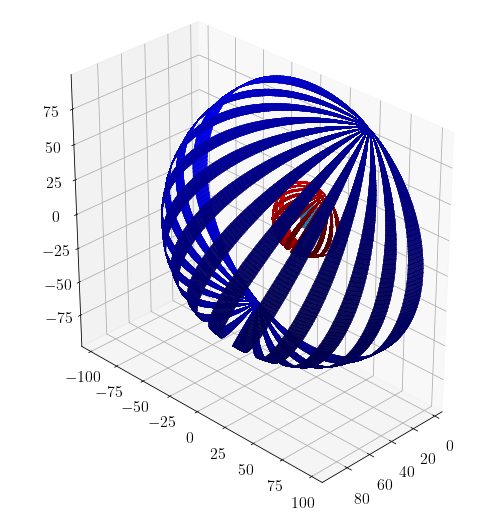

In [33]:
a.plot_collimator( 0.0)

In [81]:
a.calc_rotation_source(90.0)

(450.0, -200.0, 450.0)

In [85]:
pp = a.calc_rotation_detector(30.0)

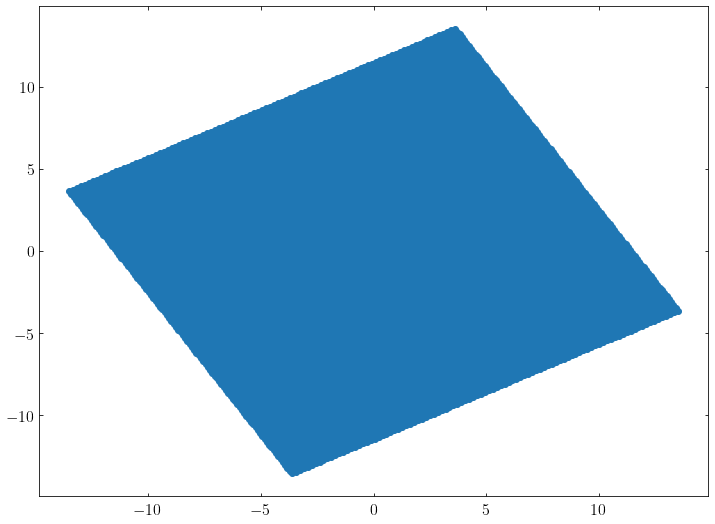

In [86]:
plt.scatter(pp[1], pp[2])

In [17]:
isinstance(a, np.ndarray)

True

In [16]:
type(np.ndarray)

type

In [29]:
f"{3.336:.2f}"

'3.34'

In [59]:
%timeit calc_rotation_old([200, 200, 200])

1.35 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
%timeit calc_rotation([200, 200, 200])

30.7 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [102]:
a=np.array([1,2,3])
b=a.copy()

In [103]:
b[1]=-2

In [104]:
a

array([1, 2, 3])

In [101]:
b

array([ 1, -2,  3])